# Filtrando ruído com autoencoder convolucional

Nesta aplicação o autocodificador é utilizado como filtro de ruído. 
Utiliza-se o dataset do MNIST, adicionando ruído gaussiano.
A rede é treinada com a entrada com a imagem ruidosa e a saída como a imagem original.

Esta é uma rede totalmente convolucional e para tanto, a rede aceita imagens de entrada de quaisquer dimensões.

## Importando as bibliotecas

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# from os
import os.path

# from torch
import torch
from torch import nn
from torch.autograd import Variable

# from torchvision
import torchvision
from torchvision.datasets import MNIST

# from course libs
import lib.pytorch_trainer as ptt

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: False


## Carregando os dados

In [3]:
dataset_dir = './data/datasets/MNIST/'
processed_folder = 'processed'
training_file = 'training.pt'
test_file = 'test.pt'

# Download dos dados caso não existam
if not (os.path.exists(os.path.join(dataset_dir, processed_folder, training_file)) and
    os.path.exists(os.path.join(dataset_dir, processed_folder, test_file))):
    dataset_train = MNIST(dataset_dir, train=True, download=True)
    del dataset_train

# Carrega dados processados do disco
train_labels, _ = torch.load(os.path.join(dataset_dir, processed_folder, training_file))
test_labels, _ = torch.load(os.path.join(dataset_dir, processed_folder, test_file))

## Normalizando os dados e criando imagens com ruídos

In [4]:
# Normaliza os dados
train_labels = train_labels.type(torch.FloatTensor)/255
test_labels = test_labels.type(torch.FloatTensor)/255

# Cria imagens com ruído
noise_factor = 0.5
train_noisy = train_labels + torch.from_numpy(noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_labels.shape)).type(torch.FloatTensor)
test_noisy = test_labels + torch.from_numpy(noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_labels.shape)).type(torch.FloatTensor)

train_noisy = torch.clamp(train_noisy, 0., 1.)
test_noisy  = torch.clamp(test_noisy, 0., 1.)

# Adciona canal
train_noisy = train_noisy.view(-1, 1, 28, 28)
train_labels = train_labels.view(-1, 1, 28, 28)
test_noisy = test_noisy.view(-1, 1, 28, 28)
test_labels = test_labels.view(-1, 1, 28, 28)

print('amostras para treinamento:', len(train_noisy))
print('amostras para validação:',   len(test_noisy))

amostras para treinamento: 60000
amostras para validação: 10000


## Mostrando algumas imagens do conjunto de treinamento

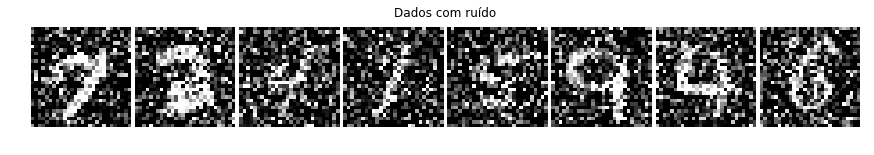

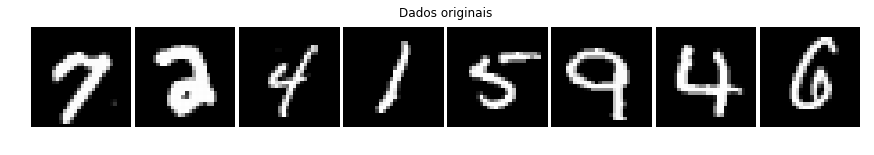

In [5]:
n_samples = 8

# cria um DataLoader temporario para pegar um batch de 'n_samples' imagens de treinamento
temp_train = torch.utils.data.TensorDataset(train_noisy, train_labels)
temp_dataloader = torch.utils.data.DataLoader(temp_train, 
                                              batch_size = n_samples,
                                              shuffle=True, num_workers=4)

# pega um batch de imagens
image_batch, labels = next(iter(temp_dataloader))

# cria um grid com as imagens
grid_data = torchvision.utils.make_grid(image_batch, normalize=True, pad_value=1.0, padding=1)
grid_labels = torchvision.utils.make_grid(labels, normalize=True, pad_value=1.0, padding=1)

# dados com ruído
plt.figure(figsize=(15, 10))
plt.title("Dados com ruído")
plt.imshow(grid_data.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()
# dados originais
plt.figure(figsize=(15, 10))
plt.title("Dados originais")
plt.imshow(grid_labels.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

del temp_dataloader

## Teste inicial com pouquíssimas amostras

In [6]:
testing = False
if testing:
    n_samples = 800
    train_noisy = train_noisy[:n_samples]
    train_labels = train_labels[:n_samples]
    
    n_samples_test = 200
    test_noisy = test_noisy[:n_samples_test]
    test_labels = test_labels[:n_samples_test]

## Cria DataLoader para os dados

In [7]:
batch_size = 64

train = torch.utils.data.TensorDataset(train_noisy, train_labels)

train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

test = torch.utils.data.TensorDataset(test_noisy, test_labels)

test_loader = torch.utils.data.DataLoader(test,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4)

## Definição das classes que representam as redes

In [8]:
import torch.nn.functional as F

# classe do AutoEncoder (Encoder + Decoder)
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# classe do Encoder
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encode_conv1 = torch.nn.Conv2d(1, 16, 3, stride=3, padding=1)
        self.encode_pool1 = torch.nn.MaxPool2d(2, stride=2)
        self.encode_conv2 = torch.nn.Conv2d(16, 8, 3, stride=2, padding=1)
        self.encode_pool2 = torch.nn.MaxPool2d(2, stride=1)

    def forward(self, x):
        x = F.relu(self.encode_conv1(x))
        x = self.encode_pool1(x)
        x = F.relu(self.encode_conv2(x))
        x = self.encode_pool2(x)
        return x

# classe do Decoder
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decode_conv1 = torch.nn.ConvTranspose2d(8, 16, 3, stride=2)
        self.decode_conv2 = torch.nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1)
        self.decode_conv3 = torch.nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1)
        
    def forward(self, x):
        x = F.relu(self.decode_conv1(x))
        x = F.relu(self.decode_conv2(x))
        x = F.tanh(self.decode_conv3(x))
        return x

## Rede autoencoder

In [9]:
autoencoder = AutoEncoder(Encoder(), Decoder())
if use_gpu:
    autoencoder = autoencoder.cuda()

## Sumário da rede

Observe que nesta rede, as dimensões das imagens em todas as camadas podem ser quaisquer, com exceção dos canais (última dimensão) que são 1 na entrada (imagem de cinza) e 1 na saída (imagem de cinza).
Assim, esta rede é dita totalmente convolucional, aceitando portanto imagens de cinza de qualquer tamanho.

In [10]:
print(autoencoder)

AutoEncoder(
  (encoder): Encoder(
    (encode_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (encode_pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (encode_conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (encode_pool2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), dilation=(1, 1), ceil_mode=False)
  )
  (decoder): Decoder(
    (decode_conv1): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (decode_conv2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (decode_conv3): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  )
)


## Treinamento da rede

In [11]:
optimizer = torch.optim.Adam(autoencoder.parameters())
criterion = nn.MSELoss()
savebest = ptt.ModelCheckpoint('../../models/FiltrandoRuidoAutoencoder',reset=True, verbose=1)

# Cria o objeto para treinar a rede
trainer = ptt.DeepNetTrainer(
    model       = autoencoder,
    criterion   = criterion, 
    optimizer   = optimizer,
    callbacks   = [ptt.PrintCallback(),savebest]
)

In [12]:
trainer.fit_loader(50, train_data=train_loader, valid_data=test_loader)

Start training for 50 epochs
  1:  14.3s   T: 0.05604   V: 0.04713 best
  2:  11.4s   T: 0.04584   V: 0.04421 best
  3:  13.0s   T: 0.04401   V: 0.04301 best
  4:  13.0s   T: 0.04315   V: 0.04224 best
  5:  12.9s   T: 0.04257   V: 0.04183 best
  6:  12.9s   T: 0.04217   V: 0.04163 best
  7:  12.9s   T: 0.04188   V: 0.04114 best
  8:  12.9s   T: 0.04161   V: 0.04101 best
  9:  12.8s   T: 0.04140   V: 0.04089 best
 10:  12.8s   T: 0.04123   V: 0.04074 best
 11:  12.9s   T: 0.04107   V: 0.04053 best
 12:  13.1s   T: 0.04094   V: 0.04054 
 13:  12.9s   T: 0.04083   V: 0.04023 best
 14:  11.0s   T: 0.04072   V: 0.04000 best
 15:  10.8s   T: 0.04063   V: 0.04016 
 16:  12.9s   T: 0.04055   V: 0.04021 
 17:  12.9s   T: 0.04051   V: 0.04005 
 18:  13.0s   T: 0.04041   V: 0.03991 best
 19:  13.0s   T: 0.04038   V: 0.04008 
 20:  10.7s   T: 0.04031   V: 0.03983 best
 21:  13.0s   T: 0.04027   V: 0.03962 best
 22:  10.7s   T: 0.04020   V: 0.03967 
 23:  12.1s   T: 0.04015   V: 0.03965 
 24:  11.3

## Testando 8 primeiras amostras de teste

In [13]:
test_hat = trainer.predict_loader(test_loader)

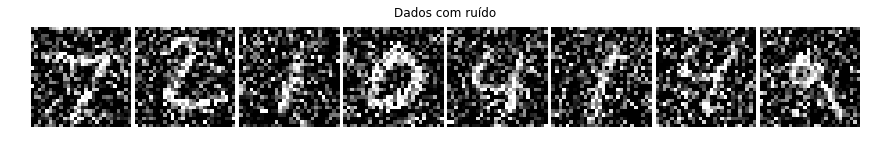

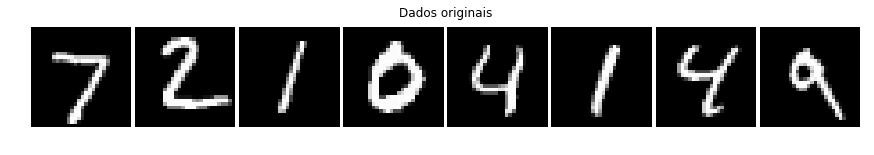

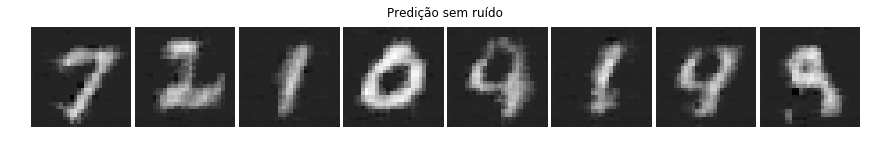

In [14]:
# cria um grid com as imagens
grid_hat = torchvision.utils.make_grid(test_hat[:8], normalize=True, pad_value=1.0, padding=1)
grid_data = torchvision.utils.make_grid(test_noisy[:8], normalize=True, pad_value=1.0, padding=1)
grid_labels = torchvision.utils.make_grid(test_labels[:8], normalize=True, pad_value=1.0, padding=1)

# dados com ruído
plt.figure(figsize=(15, 10))
plt.title("Dados com ruído")
plt.imshow(grid_data.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()
# dados originais
plt.figure(figsize=(15, 10))
plt.title("Dados originais")
plt.imshow(grid_labels.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()
# predição sem ruído
plt.figure(figsize=(15, 10))
plt.title("Predição sem ruído")
plt.imshow(grid_hat.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Testando com imagem de tamanho maior

Como a rede é formada de camadas convolucionais, é possível que a imagem de entrada tenha qualquer tamanho.
Veja o exemplo a seguir, onde 4 imagens são juntadas para formar uma de shape=(56,56).

(1, 56, 56, 1)


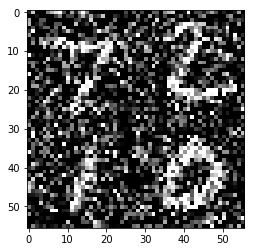

In [15]:
img1 = np.hstack([test_noisy[0].numpy().reshape(28,28),test_noisy[1].numpy().reshape(28,28)])
img2 = np.hstack([test_noisy[2].numpy().reshape(28,28),test_noisy[3].numpy().reshape(28,28)])
img = np.vstack([img1,img2]).reshape(1,56,56,1)
print(img.shape)
plt.imshow(img.reshape(56,56),cmap='gray')
                 

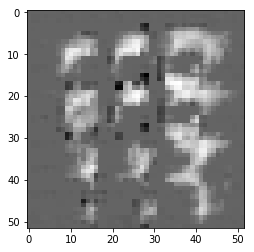

In [16]:
test_hat_large = trainer.predict(torch.Tensor(img.reshape(1,1,56,56)))
plt.imshow(test_hat_large.numpy().reshape(52,52),cmap='gray');

## Aprendizados